# An Evaluation of Time Series Anomaly Detection Using Keras
## Jon Ishaque G00398244
## Machine Learning and Statistics
## HDip in Computing with Data Analytics
## Atlantic Technical University

***

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

## 1. Introduction

"Anomaly detection addresses the problem of identifying points and/or patterns that do not conform to an expected sense of normality in a dataset". (Singh and Olinsky, 2017). This note notebook attempts to explain the keras timesseries_anomaly_detection model. 

The notebook will explain the data used in the notebook, how the preprocessing of the data - preparing it for the model - including an explanation of time windows. The neural network an anev

In [1]:
#Numerical arrays and functions
import numpy as np

#Spreadsheet-like Data Frames
import pandas as pd

#Creating Neural Networks
import tensorflow.keras as keras

#layers of neural networks?
from tensorflow.keras import layers
#Python plotting library
from matplotlib import pyplot as plt

## 2. Data

***

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

#also shows best methods for datasets
what is standard profile
reward low fp
rewand low fn?

"Anomaly detection addresses the problem of identifying points and/or patterns that do not conform to an expected sense of normality in a dataset". (Singh and Olinsky, 2017)
This evaluation will us the Numenta Anomaly Benchmark(NAB) dataset. The datasets contains labelled anomolous periods of behaviour with both artificial and real data to enable anomaly detection benchmarking. That is to say, these datasets can be used to calibrate anomaly detection algorithms. This demonstration will use the __art_daily_small_noise__ dataset and the __art_daily_jumpsup__ data set. The art indicates this is artificial data and the daily that we are looking the time series is data over one day and the timestamp indicates 5 minute intervals. Small noise suggest that some background noise has been added. Jumps_up is the data set with the anomaly. The values have 10 or 15 decimal places, but they are artificial, so the degree of accuracy has no real meaning. (The no noise dataset has no decimal places, so maybe this was an air temperature simulation)

#### 2.1 Accessing the data

In [2]:
# Get the root URL for ease of handling and to ease presentation
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

#Create the url for the data file without anomaly.

no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

#Create the url for the data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

Read in small noise no anomally into a PANDAS data frame: df_small_noise

In [5]:
# first line is column headers, use 'timestamp' as index column
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

Read in daily_jumps up data set into a PANDAS data frame: df_daily_jumpsup

In [6]:
# first line is column headers, use 'timestamp' as index column
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

#### 2.2 Investigate the small noise data set.

This is the timeseries data without an anomaly. 

In [7]:
# display top of small noise data set
df_small_noise.head()


,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


Describe the small noise data frame

samples are taken every 5 minutes

24 * 60/5 = 288 samples per day

288 * 14 day period 

 = 4032 samples

In [8]:
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


Look at first row of small noise dataframe
PANDAS appears to round to 6 places the value when looking at the row

In [9]:
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

Look at value at first row of small_noise dataframe directly as a value, the value is rounded to 10
on colname, __value__.


In [10]:
df_small_noise.iloc[0]['value']

18.3249185392

or from PANDAS values column 0

In [11]:
df_small_noise.iloc[0].values[0]

18.3249185392

Muliply by 10e12 to see if PANDAS or Jupyter has actually rounded the numbers

In [12]:
df_small_noise.iloc[0].values[0] * 10e13

1832491853919999.8

Shape of small noise dataframe is 4032 rows by 2 columns

In [13]:
df_small_noise.shape

(4032, 1)

Visualising the df_small_noise data frame (no anomaly)
The 14 day time series shows data values at 5 minute intervals. The values increase at around 9.00am each day and fall off around 6.00pm each day. And indeed there is no visual anomaly.

This will be the training dataset.

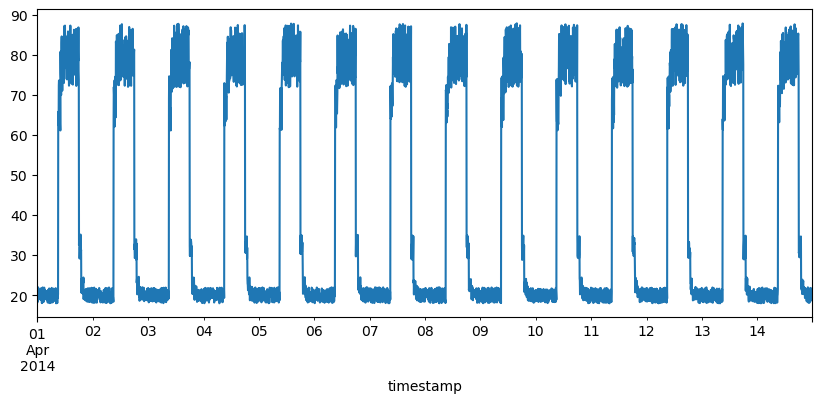

In [14]:
# use plt to make the plot size
fig, ax = plt.subplots(figsize=(10,4))

# Use PANDAS to plot small noise data frame (no anomalies).

df_small_noise.plot(legend=False, ax=ax); #semi colon hides return value!

#### 2.2 Investigate the daily jumps dataset
This is the data set where we expect an anomaly, to be detected by keras tensor flow.

In [15]:
# display the top 5 rows of the daily_jumps dataset
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


Like the small noise dataset
samples are taken every 5 minutes

24 * 60/5 = 288 samples per day

288 * 14 day period

= 4032 samples

note the max value in the jumps up data set is 164.947481, amost 4 times the mean, the max is twice the max in of the no anomaly dataset but min of both data sets is around 18. The demonstration may well show the anomaly is above the normal of the of the  anomaly data set, rather than below it.

In [16]:
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


Look at first row of daily jump dataframe

In [17]:
df_daily_jumpsup.iloc[0]

value    19.761252
Name: 2014-04-01 00:00:00, dtype: float64

Look at the first value at first row of daily jump dataframe

In [18]:
df_daily_jumpsup.iloc[0]['value']

19.761251903

Shape of daily jump set is 4032 rows by 2 columns. 

In [19]:
df_daily_jumpsup.shape

(4032, 1)

Visualising the daily jump data set. The 14 day time series shows values at 5 minute intervals. The values increase at around 9.00am each day and fall off around 6.00pm each day. Visually, there is clear an anomoly on day 11 in the daytime

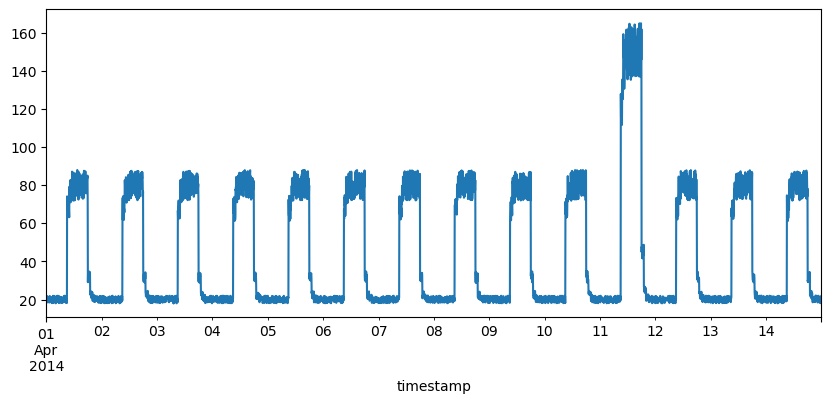

In [20]:
# use plt to visualise the dataset 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

## 3. Preprocessing
In this section we are preparing the data sets.
***

#### 3.1 Normalising and standardising the data

Get the mean value from the small noise/training dataset.

Prepare training data, get data values from the training timeseries data file and normalize the value data. subtract by the mean training value and divide by the training standard deviation. This is where unites for data sets may be of different scales (or ends of the spectrum). This maintains the relavive difference between value but centres values around zero and the standard deviation is one.

https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Normalization%20is%20useful%20when%20your,Gaussian%20(bell%20curve)%20distribution.

In [21]:
#get mean
train_mean = df_small_noise.mean()
#print mean
train_mean

value    42.438353
dtype: float64

Get the standard deviation for the small noise/training data set

In [22]:
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

Prepare training data, get data values from the training timeseries data file and normalize the value data.
subtract by the mean training value and divide by the training standard deviation. This is 

https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Normalization%20is%20useful%20when%20your,Gaussian%20(bell%20curve)%20distribution.

In [23]:
# subtract by mean of values and div by mean mean to centre on zero. scale down by bringing all scales between -.5 and 1.5

df_train_vals = (df_small_noise - train_mean) / train_std

In [24]:
# shape now 4032 rows by 4 cols
df_train_vals.shape


(4032, 1)

Display values at first row

In [25]:
df_train_vals.iloc[0]


value   -0.858829
Name: 2014-04-01 00:00:00, dtype: float64

Optional show the data

In [26]:
display(df_train_vals)

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


#### 3.1.1 Add columns to the the small df_small noise.

This to juxtapose the changes we have made with the original values.

Add a new column 'less mean' to the df_small noise

In [27]:
# add less mean col
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()


Add a new column, 'div_std' small noise minus mean divided by the std

In [28]:

df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

This enables us to see what we have done with data before we assigned it to the df_train_vals data frame

In [29]:
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


Now get the mean of the 3 columns.

The mean of __value minus mean__ and __mean of std__ will be almost zero



In [30]:
#get mean less mean, and mean div of std
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

Now get the std of the three columns

The std of mean minus mean will be, mean!

The std of val divided by std will be 1.

In [31]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

This demonstrates that the we have maintained the relationships between the values but std is 1.
Below, we visualise the new df_train_vals array and observe it visually it is similar to the original df_small_noise plot. i.e. the range of this y axis is now between 
-.08 and 1.5. That the low values are closer to -.05 and the high values are closer to 1.5 suggests there are more low values than high values. 

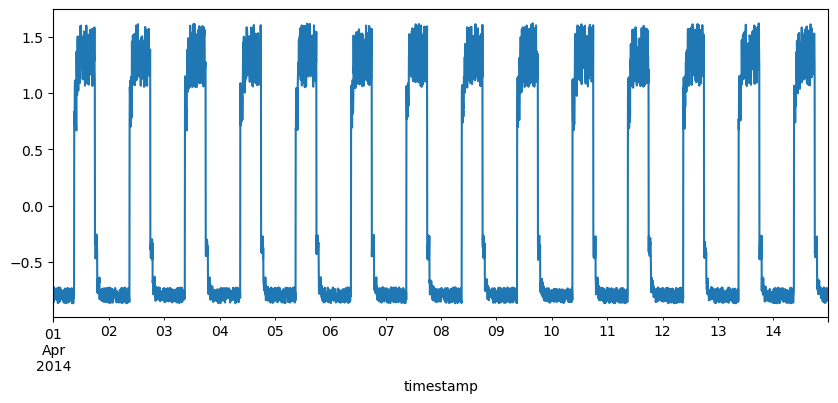

In [32]:
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame
df_train_vals.plot(legend=False, ax=ax);

Prepare training data Get data values from the training timeseries data file and normalize the value data. We have a value for every 5 mins for 14 days.

24 * 60 / 5 = 288 winows per day 288 * 14 = 4032 data points in total

In [33]:
# print number of training values
df_train_vals.shape

(4032, 1)

#### 3.1.2 Creating Windows

We are going to slide this across the 4032 values
because one window is one day with 288 samples.This could be useful because we are looking for change and patterns over time.  We already know there are 288 values taken every 5 minutes during the day so this is a good start. By creating windows we can look at data values within the window.

"We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned."
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In our demonstration we are using 288 steps as the input.

In [34]:
#This is the windows size we will use on the df_train_values

window_size = 288

#### 3.1.2.1 Dry run example with 3 step windows.


A Window example:
Explains how the window works.
In this example for the array L we will use a window size of 3,

```python
A list of values:
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
window_size = 3
1st window 
[1, 1, 2]

2nd window 
[ 1, 2, 4]

3rd window 
[2, 4, 5]

etc
[4, 5, 6]
...

Each window (list) as will be appended to another list.
The final output will be:
    [[1, 1, 2],[2, 4, 5],[4, 5, 6],[5, 6, 7],[6, 7, 1],[7, 1, 2],[1, 2, 3],[3, 4, 5]]
```

In [35]:
# The above example worked
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
eg_win_size = 3
# Length of L.
#len(L)

To get the number of windows lenght of values minus window size + 1

In [36]:
# Remove brackets.
#The number of windows will be:
len(L) - eg_win_size + 1

10

In [37]:
# create array to store the windows
eg_wins = []
#append each window  to the new array
#values at position in array and all values to val postion plus window size.
for i in range(len(L) - eg_win_size + 1):
    eg_wins.append(L[i:i + eg_win_size])
# Convert to a 2d numpy array from wins.
np.stack(eg_wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

#### 3.1.2.2 Create windows for df_train_vals datafreame

Function to create the windows and outut an array. 
Parameters: vals - the values, N - the size of the windows we want to create.

In [38]:
#create a window function to create windows array based on 
def windows(vals, N=window_size):
  # empty array.
  L = []
  # Loop through all possible windows
  for i in range(len(vals) - N + 1): # to generate windows which will never be smaller than window size. So length of values, - window size +1
    # append each window to the list
    L.append(vals[i:i+N])
  # return stacked windows
  return np.stack(L)


Call the function for df_train_vals

In [39]:
# create windows for training values
#passing the whole dataframe
# x_train is our training data set
x_train = windows(df_train_vals)

The shape of the array is 3754, windows of 288 x 1 arrays, ie. each value in the window is an array itself because we passed a whole dataframe to the function.
In this demonstration we stop at 3754 because our final array begins at this posisiton.


In [40]:
x_train.shape

(3745, 288, 1)

View the stacked array

In [41]:
x_train

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

In [42]:
# print first value of first window and last value of last widow and of last window
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [43]:
# rounded
#get first and last row of training values
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [44]:
# number of training examples. in 288 windows.
# 
#from 4032 we end up with 3745 examples because we stop at 3745
#or else windows will get progressively smaller after window 3745
x_train.shape
#print(x_train)

(3745, 288, 1)

Flatten the array to make

In [57]:
# now flatten the array into a 1d array of 3745 values.
x_train


array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

In [59]:
#x_train[0].flatten()

x_train[0]

array([[-0.85882857],
       [-0.72899302],
       [-0.84814772],
       [-0.72958579],
       [-0.731173  ],
       [-0.75730984],
       [-0.77645641],
       [-0.7880838 ],
       [-0.747012  ],
       [-0.829166  ],
       [-0.80377285],
       [-0.7821597 ],
       [-0.81182078],
       [-0.80949918],
       [-0.82334701],
       [-0.79001779],
       [-0.74922405],
       [-0.84169024],
       [-0.73727717],
       [-0.77223023],
       [-0.75311352],
       [-0.79116337],
       [-0.75934728],
       [-0.86809294],
       [-0.75381057],
       [-0.86468256],
       [-0.74361965],
       [-0.72908121],
       [-0.82850668],
       [-0.84043795],
       [-0.76136364],
       [-0.8343536 ],
       [-0.74708881],
       [-0.85574949],
       [-0.85245676],
       [-0.73090636],
       [-0.77440264],
       [-0.74974936],
       [-0.82419543],
       [-0.77402585],
       [-0.78574242],
       [-0.7844733 ],
       [-0.77316412],
       [-0.78843253],
       [-0.80927467],
       [-0

In [60]:
x_train

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

So, x_train is the training values as a numpy array of 3745 windows.
We can now take any window and identify it on the training value visualisation

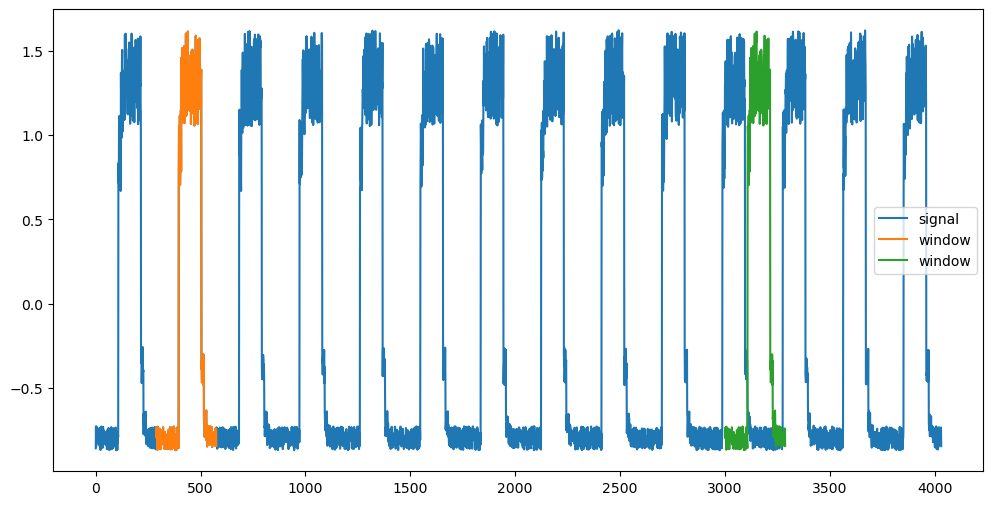

In [77]:
# We can now identify an indvidual window
window_no1 = 288
window_no2 = 3000
# create a plt plot
fig, ax = plt.subplots(figsize=(12, 6))

# plot the training values
y = df_train_vals['value'].values

# x axis is the shape of the array (time series of 4032 samples)
#  label the training values visualisation, signal
# y axis is the training values
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
# Window 200 must have been somewhere towards the end of 1st day (200 < 288) and 24 hourse or 288 * 5min intervals into the next day.
#flatten into 1 d array of 288
w1 = x_train[window_no1].flatten()
w2 = x_train[window_no2].flatten()
# 
#plot on x axis of main plot with training values.
ax.plot(np.arange(w1.shape[0]) + window_no1, w, label='window 1')
ax.plot(np.arange(w2.shape[0]) + window_no2, w, label='window 2')
ax.legend();

So what happened?
We can now visualise any window of a data sample onto our training data, although the example above is a window from the training dataset.

## 4. Neural Network

***

#### 4.1 Creating sequential the model

In [63]:
x_train.shape[1]

288

Now we use keras to build a sequential model.
shape 288 nodes as input
The first layer is the input shape.

The second layer is the 1d convolution later which is specifically useful for time series data. A kernel slides along the times series at each point as the kernel moves along the times series it reads 288 x 1 data point

convolution is the process of taking a kernel and doing a sliding dot product with the signal (value)
Take the kernel and flip it around, and then slide it along. At each point where the signal match (same time point), multiply the points on the kernel that line up with the points on the signal and then add them  together. This gives the convolution at that point. Each process is known as taking a dot product and the whole process of sliding the kernel is known as a sliding dot product.
https://end-to-end-machine-learning.teachable.com/p/321-convolutional-neural-networks
1D convolution for neural networks, part 2: Convolution copies the kernel Youtube

The drop out layer 
Dropout(rate=0.2),

As the operations continue the The convID Transpose layer reshapes the data for output because 
https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba

In [65]:
# What is the Neural Network
#create layers of?
#explain each layer
layers = [ 
  #https://keras.io/api/layers/core_layers/input/[
    #the input shape of the sequential model will be 288 x 1
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #the 1 d convolution layer is used for time sequences
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #sets input units with a rate of .2 to zero. Designed to prevent overfitting.
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

#https://jinglescode.github.io/2020/11/01/how-convolutional-layers-work-deep-learning-neural-networks/

In [66]:
# Apply the layers to the sequential model
model = keras.Sequential(layers)

Optimizers improve accuracy by reducing loss by changing attributes such as learning rates and weights in order minmises loss
The Adam optimiser uses the Adam alogrithm. Adam stands for adaptive moment estimation,it works by using past gradients to work out current gradients.  
#https://analyticsindiamag.com/guide-to-tensorflow-keras-optimizers/#:~:text=Optimizers%20are%20Classes%20or%20methods,help%20to%20get%20results%20faster.

In [78]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

The loss is constantly being calcluated is being used to get gradients of weights and used to update weights, updates occur at every interation of the network. It used in conjuction with optimizer. 
https://neptune.ai/blog/keras-loss-functions
the __mse__ function means Mean Squared Error. The mean squared error calcualtes the mean square of errors between predictions and true values.


https://keras.io/api/losses/regression_losses/#mean_squared_error-function

In [79]:
#compile the nerual network
model.compile(optimizer=optimizer, loss="mse")

In [69]:
model.summary()
#all the differnt layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

#### 4.2 Training the network

 The model fit method trains the model. The parameters are:
    
__x__ the x values, in this case the time series, keras extrapolates these from the x_train data set

__y__ the sample values, keras extrapolates these from the x_train data set

__epochs__ one epoch means the sample has been passed through the network once. Our example will do this 50 times.

__batch_size__ how many values will be passed to the the network at one time, in this example, 128

__validation_split__ this how much of the sample will be held back for the validation data set, in this case .1 or 10% of the sample - see validation loss below 

__callbacks__  callbacks are functions executed at given stages during the training. They can be triggered by events, such as epoch_end, epoch_begin.

https://blog.paperspace.com/tensorflow-callbacks/

__EarlyStopping()__ will stop the training when the accuracy is no longer improving, users can determine the level of this.

__monitor="val_loss"__ is the metric that the method is monintoring.

__mode="min"__ in this case tells the early stop should occur when the monitored metric should be decreasing 

Loss is: 

Training loss assess how a learning model fits the data, it assesses the (sum of all) error(s) of the model for each batch (the number of samples for each epoch).

val_loss (validation loss) is similar to the traing loss. It is the sum of error for a validation data set, data set aside to be used for validation at the end of each epoch.

https://www.baeldung.com/cs/training-validation-loss-deep-learning


In [70]:
# model .fit https://kera.io/sapi/models/model_training_apis/
#returns a history object - dictionary?
#find a link to the history
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
#search keras model fit....find fit method in sequential class
history = model.fit(
    #trains model oninput and output
    #no anomally ones
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 2s 36ms/step - loss: 0.4937 - val_loss: 0.0696
Epoch 2/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0809 - val_loss: 0.0399
Epoch 3/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0558 - val_loss: 0.0328
Epoch 4/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0451 - val_loss: 0.0288
Epoch 5/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0387 - val_loss: 0.0258
Epoch 6/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0346 - val_loss: 0.0235
Epoch 7/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0314 - val_loss: 0.0237
Epoch 8/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0289 - val_loss: 0.0222
Epoch 9/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0271 - val_loss: 0.0239
Epoch 10/50
27/27 [==============================] - 1s 28ms/step - loss: 0.0256 - val_loss: 0.0231
Epoch 11/

## 5. Evaluation

***

#### 5.1 Evaluating the performance of the training model

The callback functions keep a history of validation loss and the model itself keeps a training history. These values are returned as an arrays history["loss"] and history["val_loss"]

In [71]:
history.history["loss"]

[0.49365001916885376,
 0.08085252344608307,
 0.05578494071960449,
 0.04505490884184837,
 0.038669876754283905,
 0.03462502360343933,
 0.03136054426431656,
 0.028900640085339546,
 0.027085958048701286,
 0.02555626630783081,
 0.024518506601452827,
 0.02348637953400612,
 0.022711144760251045]

In [72]:
history.history["val_loss"]

[0.06957781314849854,
 0.03991954028606415,
 0.03279845044016838,
 0.028828084468841553,
 0.025757387280464172,
 0.02354091964662075,
 0.023722084239125252,
 0.022200722247362137,
 0.023936716839671135,
 0.023084033280611038,
 0.024228110909461975,
 0.024530822411179543,
 0.02509053610265255]

We can plot both loss history and see the how loss is minmised as each epoch is passed. 

In this case validation loss and training loss decrease steadily and eventually stablise at the same value. This suggests an optimal fit, a model that does not over fit nor under fit
https://www.baeldung.com/cs/training-validation-loss-deep-learning

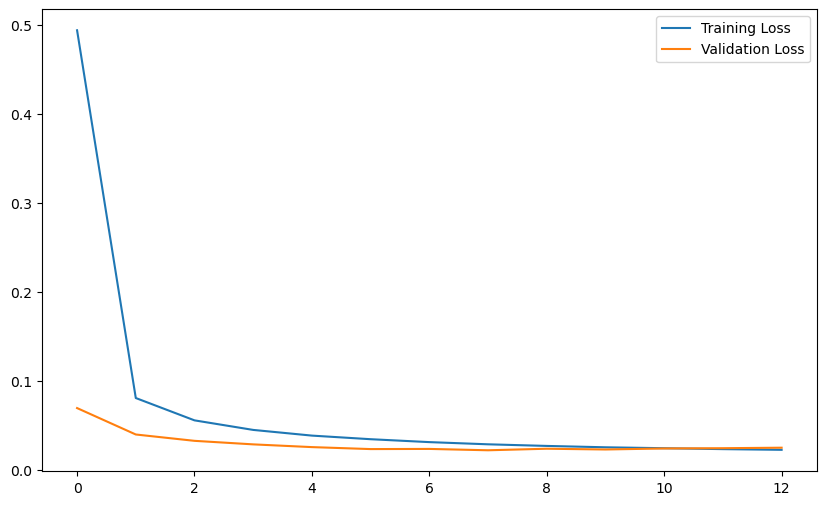

In [73]:
#history is fitted model
#loss is trainingloss
#val las is validation loss
#
fig, ax = plt.subplots(figsize = (10,6))
#
ax.plot(history.history["loss"], label="Training Loss")
#
ax.plot(history.history["val_loss"], label="Validation Loss")
#
ax.legend()

MAE loss the 
https://heartbeat.comet.ml/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
Mean Absolute Erroris the sum of absolute deifferences between target and predicted values. It is used to determine the models performance

In [82]:
# Get training dataset MAE loss.
model.predict a method of keras that predicts output based on the sample input
x_train_pred = model.predict(x_train)
#x_train_pred
#get model just trained to predict the values out of the training

118/118 [==============================] - 1s 3ms/step


array([[[-0.56927115],
        [-0.6702041 ],
        [-0.73066175],
        ...,
        [-0.7837015 ],
        [-0.74623847],
        [-0.75559396]],

       [[-0.57405907],
        [-0.67727613],
        [-0.74147934],
        ...,
        [-0.8007399 ],
        [-0.7628695 ],
        [-0.7636073 ]],

       [[-0.5717853 ],
        [-0.6741817 ],
        [-0.737437  ],
        ...,
        [-0.7970168 ],
        [-0.7589888 ],
        [-0.7581304 ]],

       ...,

       [[-0.5812211 ],
        [-0.6850845 ],
        [-0.7464828 ],
        ...,
        [-0.80135804],
        [-0.76161146],
        [-0.76572275]],

       [[-0.58022416],
        [-0.68476784],
        [-0.7495637 ],
        ...,
        [-0.800111  ],
        [-0.75754154],
        [-0.75581706]],

       [[-0.5815166 ],
        [-0.6859535 ],
        [-0.7496311 ],
        ...,
        [-0.8034286 ],
        [-0.7604816 ],
        [-0.7593022 ]]], dtype=float32)

In [109]:
# Calculate MAE loss...
#take mean, absolute value of the xtrain predciton minus xtrain on axis 1
#work how accurate precitions are are, standard way, could square it
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mae_loss

array([[0.10407613],
       [0.10233825],
       [0.104298  ],
       ...,
       [0.10566282],
       [0.10597117],
       [0.10395073]])

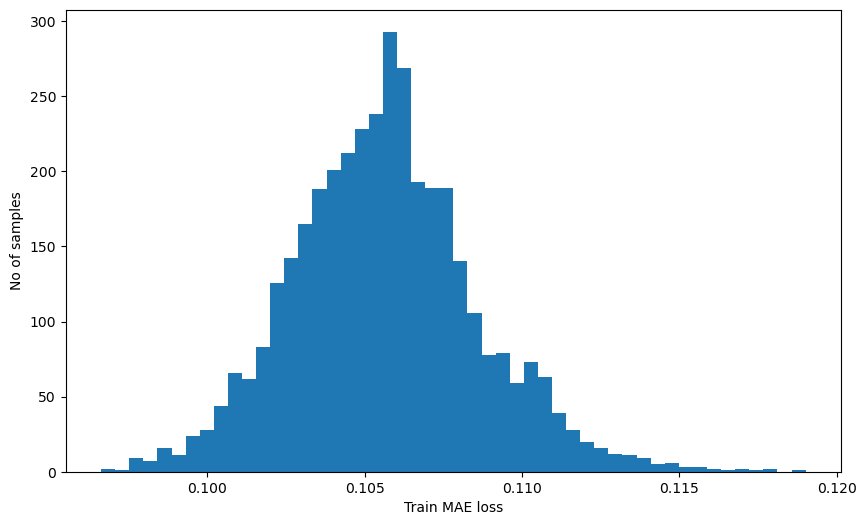

In [85]:
# plot a historgram to show sample per MAE loss
fig, ax = plt.subplots(figsize=(10, 6))
# split the range into 50 bins
ax.hist(train_mae_loss, bins=50)
# set axis label
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

If we look at the histogram once can see that all of the value are below .119
https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/

We can get the maximum value. Any test value above this threshold will be an anomally

In [91]:

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

#
threshold

0.1190163022236544

Plot the training data against the NN predicted output data.

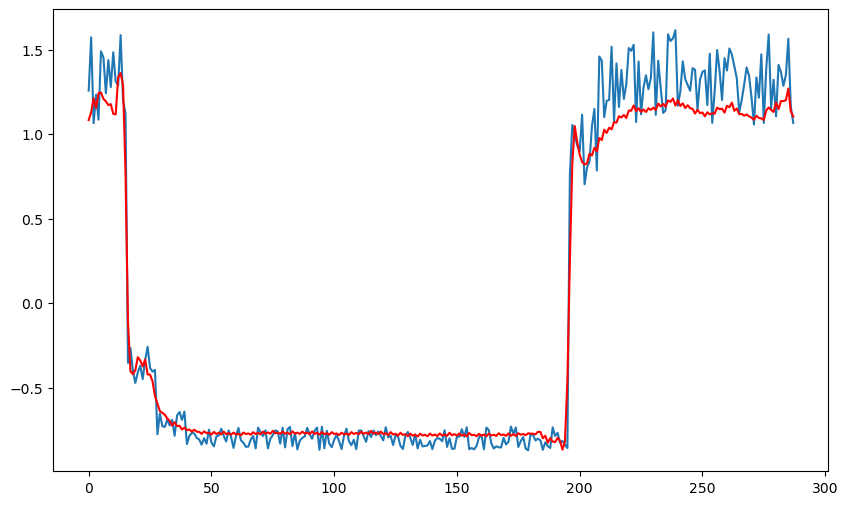

In [95]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# plot training data
ax.plot(x_train[200])

# plot predicted output data
ax.plot(x_train_pred[200],'r');

#### 5.2 Testing for anomalies

So, if network can now predict outputs from the training set. It should be able to detect anomalies 

In [96]:
Normalising and standardise the test data using the trainin std and training mean, as we did for the training data above (3.1)

#df daily jumpsup

df_test_value = (df_daily_jumpsup - train_mean) / train_std

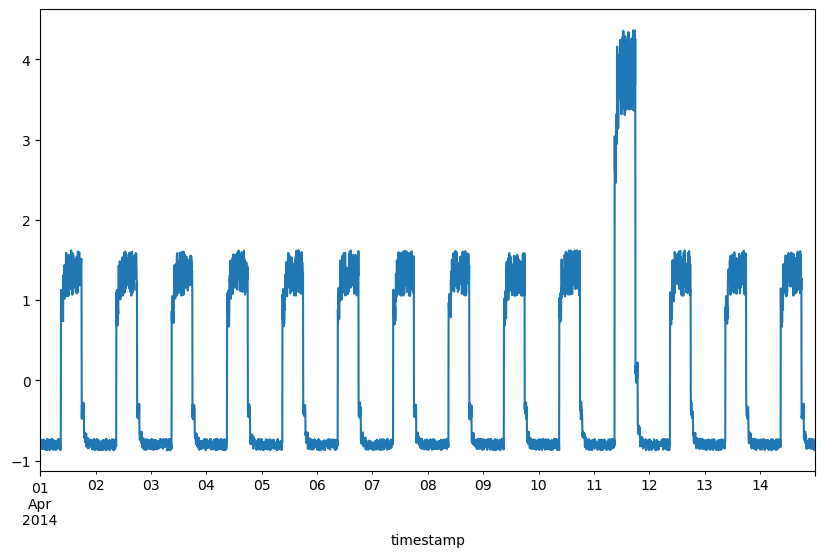

In [97]:
# Create a plot for the test data
fig, ax = plt.subplots(figsize=(10, 6))

# plot the test data
df_test_value.plot(legend=False, ax=ax);

In [107]:
# Create sequences from test values. #create windows using the previouly create windows function 
x_test = windows(df_test_value.values)
#check the shape.
x_test.shape

(3745, 288, 1)

In [108]:
# Call the model preiction function for the test data
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 4ms/step


In [120]:
# Get the MAE loss for the test data.
#
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.10330593],
       [0.10338127],
       [0.10425287],
       ...,
       [0.10380742],
       [0.10519672],
       [0.10460944]])

In [121]:
# Reshape the array test_mae_loss. Although this was not done for the training mae loss and seems to make no differece to the historgram
#test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([[0.10330593],
       [0.10338127],
       [0.10425287],
       ...,
       [0.10380742],
       [0.10519672],
       [0.10460944]])

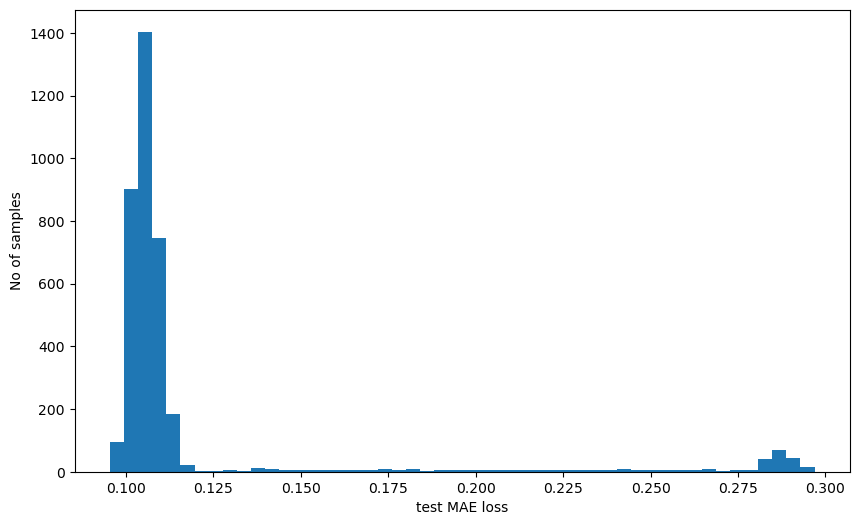

In [122]:
# Create mae loss plot
fig, ax = plt.subplots(figsize=(10, 6))

#plot test mae loss, bin size = 50
ax.hist(test_mae_loss, bins=50)

# set x label
ax.set_xlabel("test MAE loss")

# set y label 
ax.set_ylabel("No of samples");

In [ ]:
Recall from the training MAE loss, all samples were below a threshhold of .119. Ergo, samples above .119 are an anamolous

In [123]:
# Detect all the samples which are anomalies.
#https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

396

Identify samples indexes which are anomalies and append to inds

In [127]:


# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
#anomolous data indicies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)
#inds

[2989,
 2990,
 2991,
 2992,
 2993,
 2994,
 2995,
 2996,
 2997,
 2998,
 2999,
 3000,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014,
 3015,
 3016,
 3017,
 3018,
 3019,
 3020,
 3021,
 3022,
 3023,
 3024,
 3025,
 3026,
 3027,
 3028,
 3029,
 3030,
 3031,
 3032,
 3033,
 3034,
 3035,
 3036,
 3037,
 3038,
 3039,
 3040,
 3041,
 3042,
 3043,
 3044,
 3045,
 3046,
 3047,
 3048,
 3049,
 3050,
 3051,
 3052,
 3053,
 3054,
 3055,
 3056,
 3057,
 3058,
 3059,
 3060,
 3061,
 3062,
 3063,
 3064,
 3065,
 3066,
 3067,
 3068,
 3069,
 3070,
 3071,
 3072,
 3073,
 3074,
 3075,
 3076,
 3077,
 3078,
 3079,
 3080,
 3081,
 3082,
 3083,
 3084,
 3085,
 3086,
 3087,
 3088,
 3089,
 3090,
 3091,
 3092,
 3093,
 3094,
 3095,
 3096]

In [125]:
# add anomalies to df from the unstandarised test data
df_subset = df_daily_jumpsup.iloc[inds]

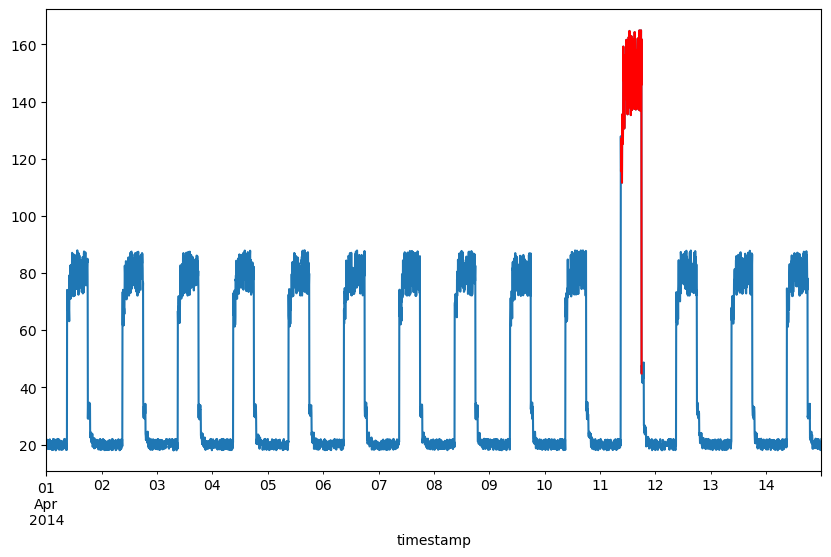

In [126]:
#create plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot test samples
df_daily_jumpsup.plot(legend=False, ax=ax)

# plot anomalous samples in red
df_subset.plot(legend=False, ax=ax, color="r");

***
References
Demystifying Numenta anomaly benchmark

Singh, N. and Olinsky, C. (2017). Demystifying Numenta anomaly benchmark. [online] IEEE Xplore. doi:10.1109/IJCNN.2017.7966038.


(Singh and Olinsky, 2017)

## End